In [17]:
# !pip install seaborn
# !pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel
import torch
is_tensor = torch.is_tensor

from sklearn.preprocessing import StandardScaler

/Users/bereket/Documents/Project and Programming Final Project/data/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/bereket/Documents/Project and Programming Final Project/data/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('reel_user.csv')
df.drop(['location', 'comments_disabled', 'title'], axis=1, inplace=True)
df.drop(['shortcode', 'video_id', 'thumb', 'url', 'username', 'profile_image', 'followers', 'follows'], axis=1, inplace=True)
df.drop(['is_private'], axis=1, inplace=True) # since all the accounts are public in this dataset 
df.drop(['user_id', 'content_id'], axis=1, inplace=True)
# df = df.dropna()
df = df.fillna(0)

In [4]:
df = df.dropna(subset=['name'])
df = df[df['name'] != 'Handsome Dan XIX']
df.shape

(1236, 9)

In [5]:
from scipy.stats import zscore

df['z_score'] = zscore(df['engagement_ratio'])
df_filtered = df[df['z_score'].abs() <= 3]
df = df_filtered
df.drop(['z_score'], axis=1, inplace=True)

In [6]:
df.head()

,comments_count,taken_at,likes,captions,views,duration,name,is_verified,engagement_ratio
0,12,1733164403,1218,Did you know Harvard has its own student-run c...,0.0,21.566668,Harvard University,True,0.000486
1,53,1732727048,3626,"Earlier this week, Harvard students partnered ...",0.0,43.814602,Harvard University,True,0.001455
2,34,1732551865,3519,Scenes from the 140th playing of The Game 🏈 \n...,0.0,44.335918,Harvard University,True,0.001405
3,66,1732201090,6519,Harvard and Yale will meet for the 140th playi...,0.0,33.741993,Harvard University,True,0.002605
4,28,1731951088,2386,Getting detailed images of the night sky is a ...,0.0,21.021656,Harvard University,True,0.000955


In [7]:
df['taken_at'] =  pd.to_datetime(df['taken_at'], unit='s')
df = df.dropna(subset=['taken_at'])


df['day'] = df['taken_at'].dt.day
df['month'] = df['taken_at'].dt.month
df['year'] = df['taken_at'].dt.year

df['hour'] = df['taken_at'].dt.hour
df['minute'] = df['taken_at'].dt.minute
df['second'] = df['taken_at'].dt.second
df.drop(['taken_at'], axis=1, inplace=True)
df.shape

(1227, 14)

In [8]:
columns = df.columns.tolist()
columns.remove('engagement_ratio')

In [9]:
features, target =  df[columns].values, df['engagement_ratio'].values
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler()
# df['engagement_ratio'] = scaler.fit_transform(df[['engagement_ratio']]) 
# df['engagement_ratio'] = np.log(df['engagement_ratio'].apply(lambda e: e))

In [11]:
df = df.dropna(subset=['engagement_ratio'])
df.shape

(1227, 14)

### Finding the best time to post

In [12]:
# df['is_private'] = df['is_private'].astype(bool)
df['is_verified'] = df['is_verified'].astype(bool)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1227 entries, 0 to 1235
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   comments_count    1227 non-null   int64  
 1   likes             1227 non-null   int64  
 2   captions          1227 non-null   object 
 3   views             1227 non-null   float64
 4   duration          1227 non-null   float64
 5   name              1227 non-null   object 
 6   is_verified       1227 non-null   bool   
 7   engagement_ratio  1227 non-null   float64
 8   day               1227 non-null   int32  
 9   month             1227 non-null   int32  
 10  year              1227 non-null   int32  
 11  hour              1227 non-null   int32  
 12  minute            1227 non-null   int32  
 13  second            1227 non-null   int32  
dtypes: bool(1), float64(3), int32(6), int64(2), object(2)
memory usage: 106.6+ KB


In [14]:
numerical_columns = df.select_dtypes(include=['int64', 'float64', 'bool', 'int32']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

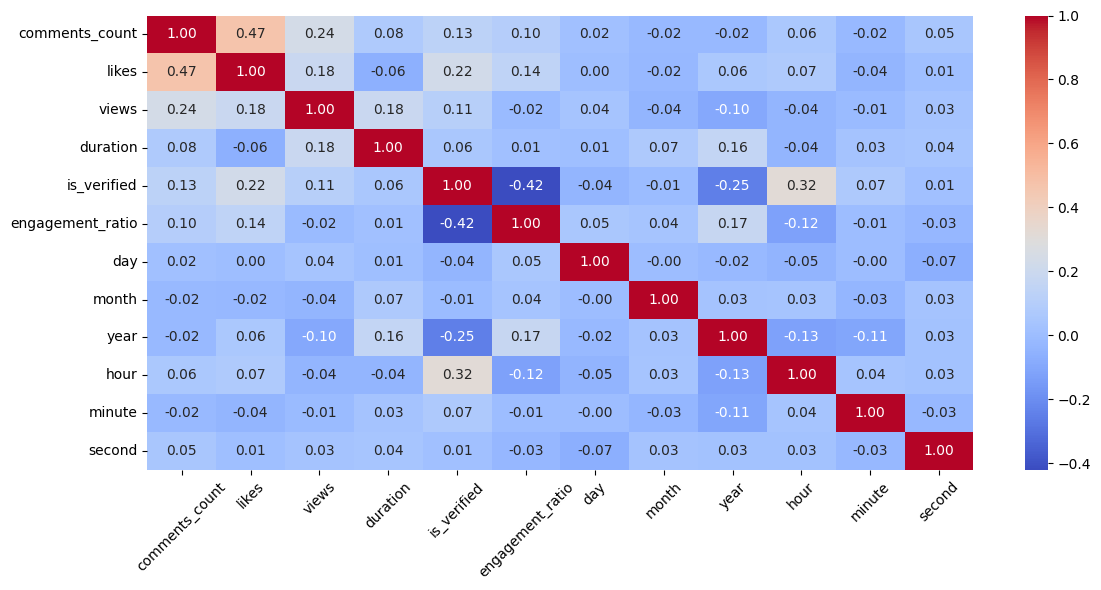

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True,  fmt=".2f", cmap='coolwarm', cbar=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
df['month'].unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1], dtype=int32)

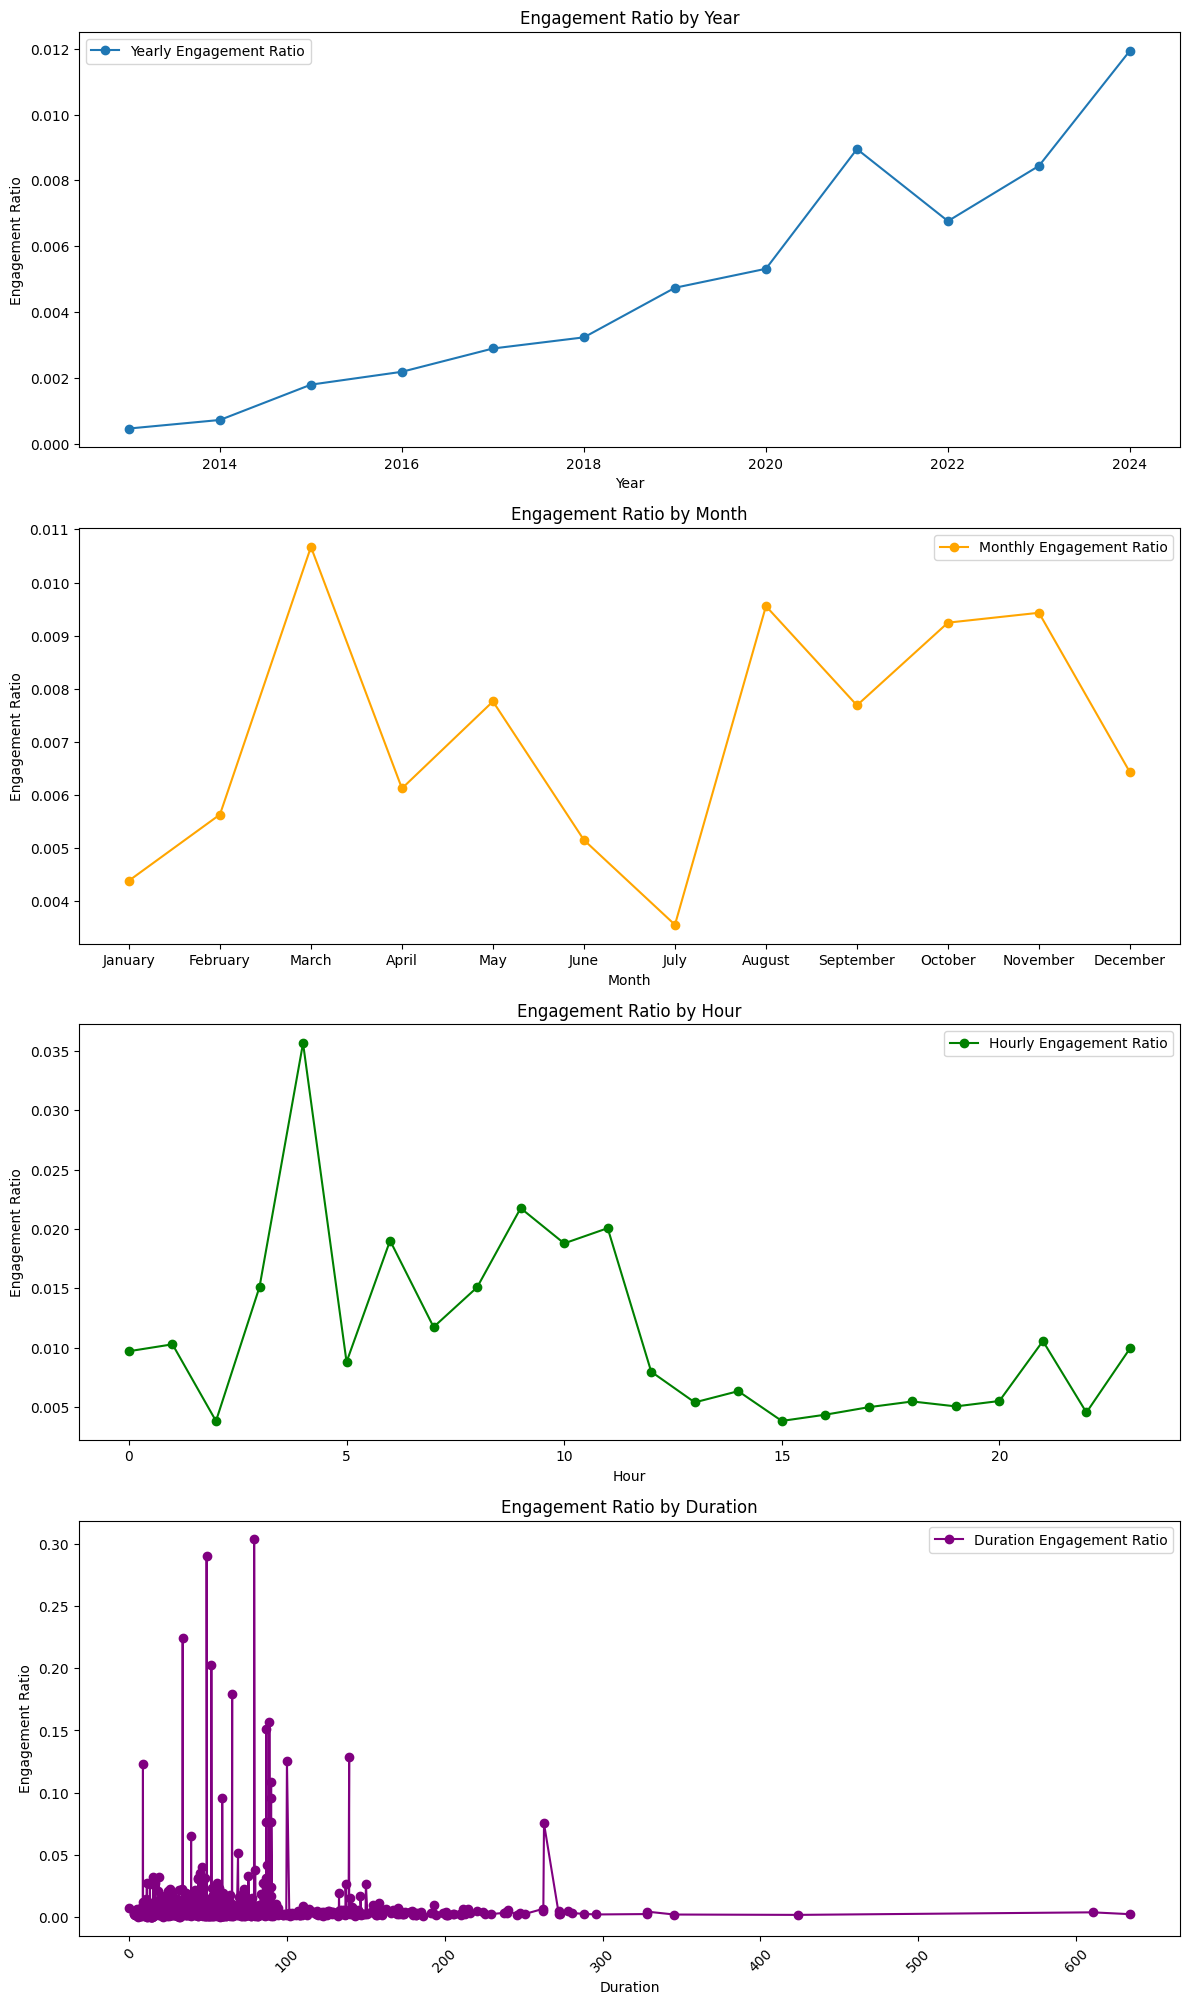

In [20]:
import matplotlib.pyplot as plt

# Extract sorted time-related columns
years = sorted(df['year'].unique().tolist())
month_val = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months = sorted(df['month'].unique().tolist())
hours = sorted(df['hour'].unique().tolist())
durations = sorted(df['duration'].unique().tolist())  # Add duration column values

# Initialize figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=False)

# Yearly engagement ratio
x_year = years
y_year = [df[df['year'] == year]['engagement_ratio'].mean() for year in years]
axes[0].plot(x_year, y_year, marker='o', label="Yearly Engagement Ratio")
axes[0].set_title("Engagement Ratio by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Engagement Ratio")
axes[0].legend()

# Monthly engagement ratio
x_month = month_val
y_month = [df[df['month'] == month]['engagement_ratio'].mean() for month in months]
axes[1].plot(x_month, y_month, marker='o', label="Monthly Engagement Ratio", color='orange')
axes[1].set_title("Engagement Ratio by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Engagement Ratio")
axes[1].legend()

# Hourly engagement ratio
x_hour = hours
y_hour = [df[df['hour'] == hour]['engagement_ratio'].mean() for hour in hours]
axes[2].plot(x_hour, y_hour, marker='o', label="Hourly Engagement Ratio", color='green')
axes[2].set_title("Engagement Ratio by Hour")
axes[2].set_xlabel("Hour")
axes[2].set_ylabel("Engagement Ratio")
axes[2].legend()

# Engagement ratio by duration
x_duration = durations
y_duration = [df[df['duration'] == duration]['engagement_ratio'].mean() for duration in durations]
axes[3].plot(x_duration, y_duration, marker='o', label="Duration Engagement Ratio", color='purple')
axes[3].set_title("Engagement Ratio by Duration")
axes[3].set_xlabel("Duration")
axes[3].set_ylabel("Engagement Ratio")
axes[3].legend()

# Adjust layout
plt.tight_layout()
plt.xticks(rotation=45)

# Show plot
plt.show()

### groupped by account name

/var/folders/q1/_7jmrlsd6zv5d7mw74_zxgbm0000gn/T/ipykernel_28353/3338258179.py:47: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q1/_7jmrlsd6zv5d7mw74_zxgbm0000gn/T/ipykernel_28353/3338258179.py:47: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q1/_7jmrlsd6zv5d7mw74_zxgbm0000gn/T/ipykernel_28353/3338258179.py:47: UserWarning: Glyph 32445 (\N{CJK UNIFIED IDEOGRAPH-7EBD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q1/_7jmrlsd6zv5d7mw74_zxgbm0000gn/T/ipykernel_28353/3338258179.py:47: UserWarning: Glyph 32422 (\N{CJK UNIFIED IDEOGRAPH-7EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q1/_7jmrlsd6zv5d7mw74_zxgbm0000gn/T/ipykernel_28353/3338258179.py:47: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q1/_7jm

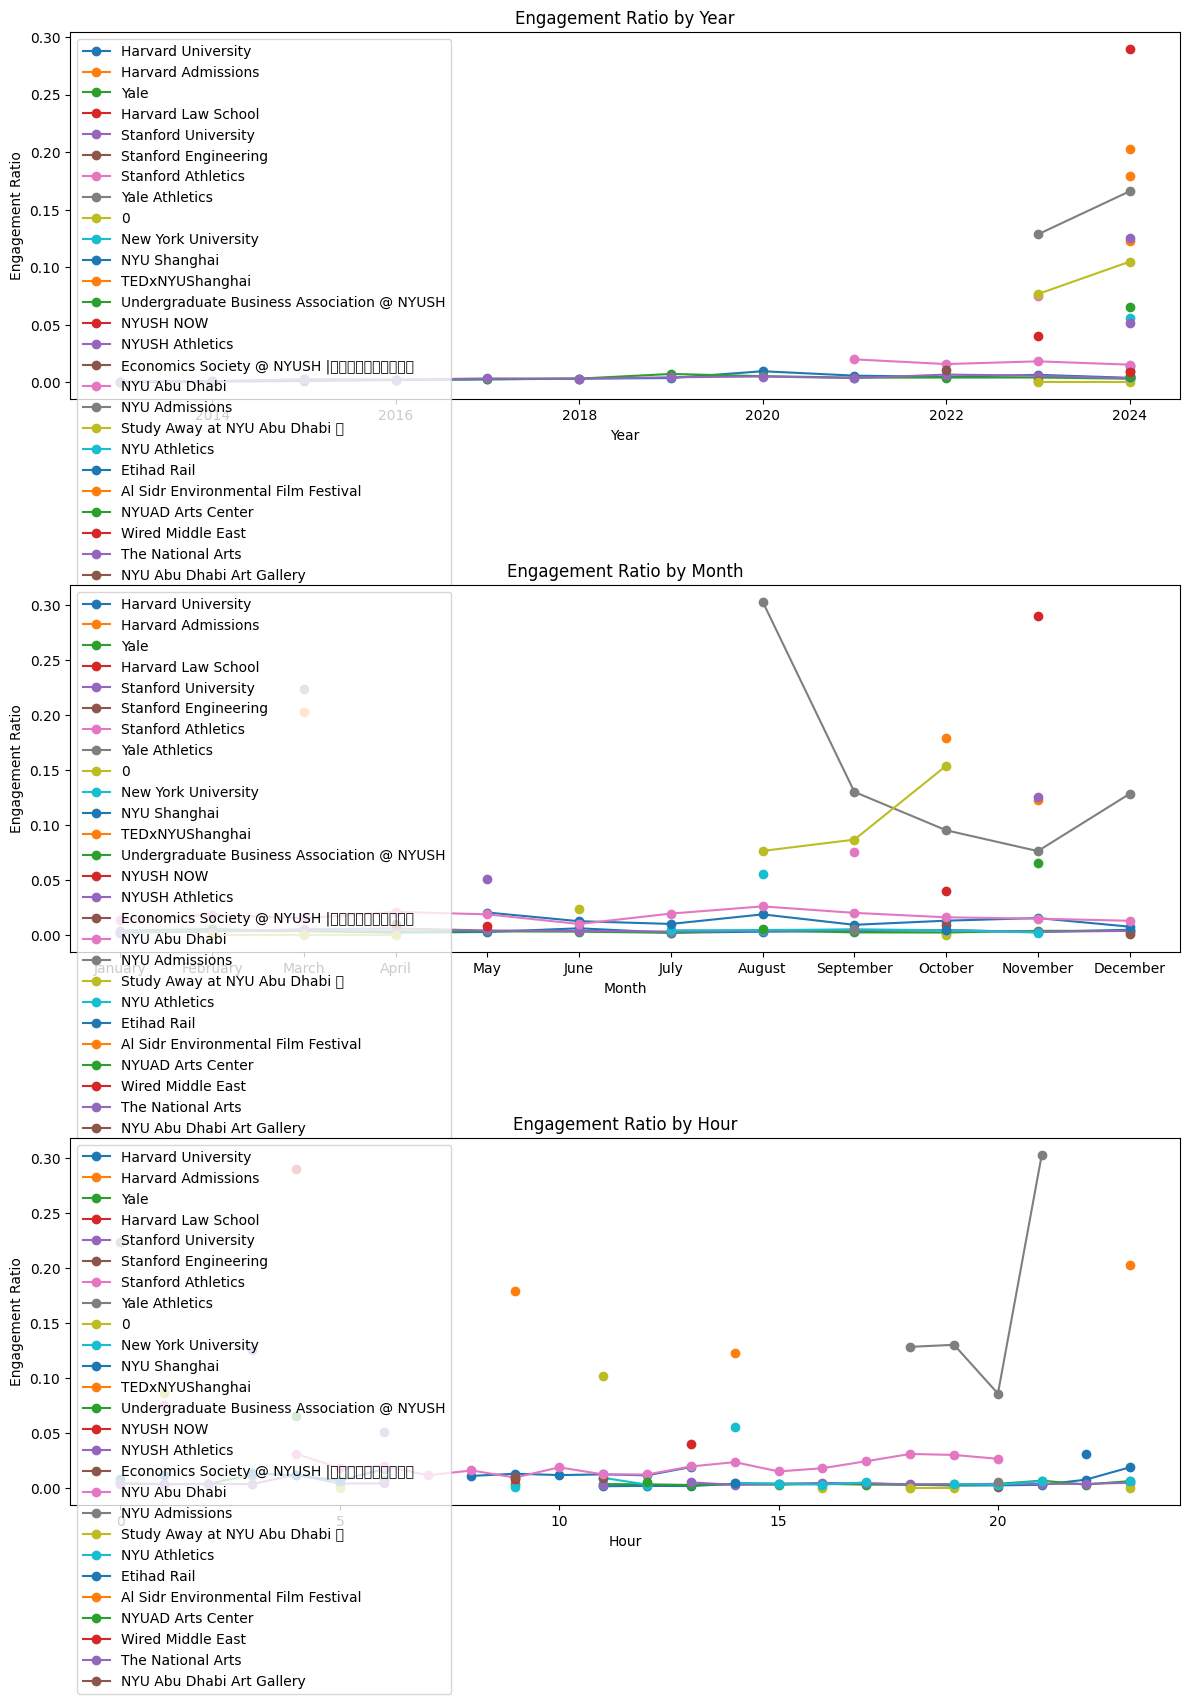

In [21]:
# Extract unique names
names = df['name'].unique().tolist()

# Define time dimensions
years = sorted(df['year'].unique().tolist())
month_val = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months = sorted(df['month'].unique().tolist())
hours = sorted(df['hour'].unique().tolist())

# Initialize figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)

# Yearly engagement ratio
for name in names:
    x_year = years
    y_year = [df[(df['year'] == year) & (df['name'] == name)]['engagement_ratio'].mean() for year in years]
    axes[0].plot(x_year, y_year, marker='o', label=name)

axes[0].set_title("Engagement Ratio by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Engagement Ratio")
axes[0].legend()

# Monthly engagement ratio
for name in names:
    x_month = month_val
    y_month = [df[(df['month'] == month) & (df['name'] == name)]['engagement_ratio'].mean() for month in months]
    axes[1].plot(x_month, y_month, marker='o', label=name)

axes[1].set_title("Engagement Ratio by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Engagement Ratio")
axes[1].legend()

# Hourly engagement ratio
for name in names:
    x_hour = hours
    y_hour = [df[(df['hour'] == hour) & (df['name'] == name)]['engagement_ratio'].mean() for hour in hours]
    axes[2].plot(x_hour, y_hour, marker='o', label=name)

axes[2].set_title("Engagement Ratio by Hour")
axes[2].set_xlabel("Hour")
axes[2].set_ylabel("Engagement Ratio")
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Model training

In [94]:
model = RandomForestRegressor(n_estimators=1540, random_state=42, verbose=0, n_jobs=-1)
model

RandomForestRegressor(n_estimators=1540, n_jobs=-1, random_state=42)

In [96]:
df['engagement_ratio'].describe()

count    5959.000000
mean       -6.092448
std         1.279546
min       -10.583275
25%        -6.809365
50%        -5.807572
75%        -5.204496
max        -0.848042
Name: engagement_ratio, dtype: float64

In [97]:
X_train, X_test, y_train, y_test = train_test_split(df[['month', 'is_verified']], df['target'], test_size=0.15, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0


In [98]:
df['target'] = df['engagement_ratio']#.apply(lambda x: round(x, 1))
df = df.dropna(subset=['target'])
df.shape

(5959, 14)

In [99]:
df['target'].value_counts(normalize=True)

target
-8.331983    0.001175
-8.145285    0.001175
-8.623180    0.000839
-8.497603    0.000839
-8.347898    0.000839
               ...   
-7.192761    0.000168
-6.923662    0.000168
-7.708508    0.000168
-7.648661    0.000168
-9.647181    0.000168
Name: proportion, Length: 5173, dtype: float64

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df[['month', 'is_verified']], df['target'], test_size=0.15, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.4839288614116104


### caption based prediction

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel

In [33]:
captions = df['captions']

In [34]:
captions = captions.apply(lambda x: str(x) if isinstance(x, str) else "")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokens = tokenizer(captions.tolist(), padding=True, truncation=True, return_tensors="pt")

In [35]:
# Perform inference
with torch.no_grad():
    outputs = model(
        input_ids=tokens['input_ids'],
        attention_mask=tokens['attention_mask']
    )
    embeddings = outputs.last_hidden_state

KeyboardInterrupt: 